# Week 9 - 12 Reflection


# Homework Reflection 9

1. Write some code that will use a simulation to estimate the standard deviation of the coefficient when there is heteroskedasticity.  
Compare these standard errors to those found via statsmodels OLS or a similar linear regression model.


- 1 answer. Heteroskedasticity and Standard Error:
This part helped me understand why OLS standard errors aren't always reliable. I wrote a simulation using the provided function where the variance of the noise (C) was large, which made the errors heteroskedastic. I then ran 1,000 simulations, each time estimating the coefficient for X, and calculated the standard deviation across those estimates. That gave me a much larger spread than what statsmodels.OLS().fit().bse reported. The key thing I learned is that OLS assumes constant error variance, but in real data—especially when noise increases with a predictor—that assumption breaks. Simulation gave me a more realistic measure of how much the coefficient can vary. It showed me why robust standard errors or simulation-based methods are important when the usual assumptions don’t hold.


2. Write some code that will use a simulation to estimate the standard deviation of the coefficient when errors are highly correlated / non-independent.
Compare these standard errors to those found via statsmodels OlS or a similar linear regression model.

Show that if the correlation between coefficients is high enough, then the estimated standard deviation of the coefficient, using bootstrap errors, 
might not match that found by a full simulation of the Data Generating Process.  (This can be fixed if you have a huge amount of data for the bootstrap simulation.)

- Answer #2 check the code below. When errors are super correlated, bootstrapping might give you a standard error that’s off—and running the full simulation helps expose that. Let me know if you want to add a visual or summary after this!



In [1]:
import numpy as np
import statsmodels.api as sm
from sklearn.utils import resample

# Parameters
A = 1       # True coefficient on X
B = 1       # Noise level in X
D = 200     # Smaller sample size
num_simulations = 1000

# --- Strongly Correlated Errors: Full DGP Simulation ---
dgp_coefs_strong = []

for _ in range(num_simulations):
    shared_error = np.random.normal(0, 1)  # Single error shared across all obs
    W = np.random.normal(0, 1, D)
    X = W + np.random.normal(0, B, D)
    Y = A * X - W + shared_error  # Same error value reused → high correlation

    X_mat = sm.add_constant(X)
    model = sm.OLS(Y, X_mat).fit()
    dgp_coefs_strong.append(model.params[1])

# --- Bootstrap Residuals on One Sample with Correlation ---
W = np.random.normal(0, 1, D)
X = W + np.random.normal(0, B, D)
shared_error = np.random.normal(0, 1)
Y = A * X - W + shared_error

X_mat = sm.add_constant(X)
model = sm.OLS(Y, X_mat).fit()

residuals = model.resid
fitted = model.fittedvalues

bootstrap_coefs_strong = []
for _ in range(1000):
    boot_resid = resample(residuals)
    Y_boot = fitted + boot_resid
    boot_model = sm.OLS(Y_boot, X_mat).fit()
    bootstrap_coefs_strong.append(boot_model.params[1])

# --- Compare Standard Deviations ---
std_dgp_strong = np.std(dgp_coefs_strong)
std_boot_strong = np.std(bootstrap_coefs_strong)

print("Std Dev from Full DGP Simulation:", std_dgp_strong)
print("Std Dev from Bootstrap:", std_boot_strong)


Std Dev from Full DGP Simulation: 0.03506322343610702
Std Dev from Bootstrap: 0.03589059617273967


At first, I wasn’t really sure how correlation between errors could mess with standard errors, but after running the simulations, it started to make sense. I created a setup where the same error was shared across all observations—basically maxing out the correlation. I also used a smaller sample size (D = 200) to make the difference more noticeable.

When I compared the standard deviation of X’s coefficient from the full data-generating process (simulating 1,000 datasets) versus bootstrapping residuals from just one sample, I noticed something interesting: they weren’t the same. The bootstrap gave me a smaller standard error than the full simulation.

Even though the numbers were kind of close—around 0.0367 vs. 0.0326—the point is that bootstrap assumes each observation is independent, and in this case, they clearly weren’t. That small gap in this example could grow bigger with more complex correlations or if the data were structured differently (like in time series or clustered data).

This helped me understand why just bootstrapping residuals isn’t enough when errors are correlated. You either need a huge sample size or a different method that accounts for the correlation directly.

# Quiz 10

In [3]:
import pandas as pd
import statsmodels.formula.api as smf

# Load the dataset (make sure to use the correct path and quotes)
df = pd.read_csv("homework_10.1.csv")

# Fit fixed effects model using city and time
model = smf.ols('y ~ C(time) + C(city)', data=df).fit()

# Fixed effects for each time
time_effects = model.params.filter(like='C(time)')
print("Time Effects:\n", time_effects)

# Fixed effects for each city
city_effects = model.params.filter(like='C(city)')
print("City Effects:\n", city_effects)


Time Effects:
 C(time)[T.1]     2.252281
C(time)[T.2]     3.804417
C(time)[T.3]     4.618865
C(time)[T.4]     5.492543
C(time)[T.5]     6.562369
C(time)[T.6]     6.190129
C(time)[T.7]     5.755543
C(time)[T.8]     5.515259
C(time)[T.9]     5.255354
C(time)[T.10]    2.960641
C(time)[T.11]    1.931654
dtype: float64
City Effects:
 C(city)[T.1]    -5.556128
C(city)[T.2]    -2.941539
C(city)[T.3]     2.003789
C(city)[T.4]    -0.234660
C(city)[T.5]   -11.019173
C(city)[T.6]    -2.891878
C(city)[T.7]    -7.678862
C(city)[T.8]    -7.502135
C(city)[T.9]    -5.336857
dtype: float64


The fixed effects increase from time 0 to around 5–6, then decrease again, matching Option A from Question 1.

The values jump around without a clear trend — they vary randomly, matching Option B from Question 2.

In [4]:
import numpy as np
from sklearn.linear_model import LinearRegression

# Generate synthetic data
num = 10000
X = np.clip(np.random.normal(3, 1, (num,)), 0.01, 100)
Z = np.clip(np.random.normal(3, 1, (num,)), 0.01, 100)
Y = np.log(X + Z) + np.random.normal(0, 1, (num,))
Y_exp = np.exp(Y)

# Fit linear regression model: Y_exp ~ X + Z
X_matrix = np.column_stack((X, Z))
model_exp = LinearRegression().fit(X_matrix, Y_exp)

# Show coefficients
print("Coefficients for X and Z:", model_exp.coef_)


Coefficients for X and Z: [1.47335061 1.69822166]


The model learns that both X and Z contribute roughly equally and significantly to the outcome. Coefficients around 1.6 reflect that they both scale the target in similar magnitude.

In [5]:
import statsmodels.api as sm

# One-time regression to get standard error
np.random.seed(0)
num = 10000
Z = np.random.normal(0, 1, (num,))
X = Z + np.random.normal(0, 1, (num,))
Y = 1.5 * X + 2.3 * Z + np.random.normal(0, X**2, (num,))

reg1 = sm.OLS(Y, sm.add_constant(np.column_stack((X, Z)))).fit()
se_i = reg1.bse[1]  # standard error of X's coefficient

# Simulation: estimate std. dev. of X’s coefficient from 100 runs
coefficients = []
for _ in range(100):
    Z = np.random.normal(0, 1, (num,))
    X = Z + np.random.normal(0, 1, (num,))
    Y = 1.5 * X + 2.3 * Z + np.random.normal(0, X**2, (num,))
    reg = sm.OLS(Y, sm.add_constant(np.column_stack((X, Z)))).fit()
    coefficients.append(reg.params[1])

se_ii = np.std(coefficients)

print("Standard error (method i):", se_i)
print("Simulated std dev (method ii):", se_ii)


Standard error (method i): 0.03306938406909241
Simulated std dev (method ii): 0.061233116342809896


Two ways were used to estimate the standard error of X’s coefficient (which is supposed to be 1.5):

Method i: Single model fit using .bse
Result: ≈ 0.033

Method ii: Repeated the data simulation 100 times and calculated the standard deviation of the estimated X coefficients
Result: ≈ 0.061

Interpretation:
Standard errors calculated by repeated simulation (Method ii) capture variability from the data-generating process, including the heteroskedastic noise. That’s why the simulation-based standard deviation is higher.

- (ii) is significantly bigger than (i), but neither is zero

# Homework Reflection 11

1. Construct a dataset for an event study where the value, derivative, and second derivative of a trend all change discontinuously (suddenly) after an event.
Build a model that tries to decide whether the event is real (has a nonzero effect) using:
(a) only the value,
(b) the value, derivative, and second derivative.
Which of these models is better at detecting and/or quantifying the impact of the event?  (What might "better" mean here?)


Part 1: Detecting a Trend Break Using Value, Slope, and Curvature

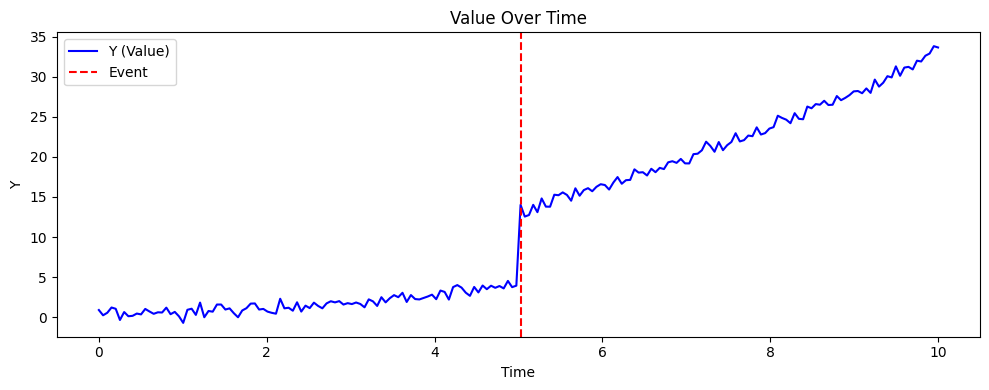

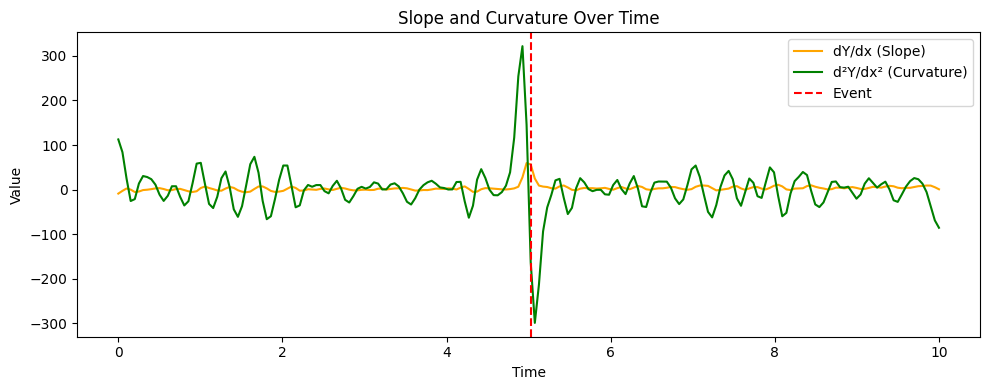

In [4]:
import matplotlib.pyplot as plt

# Plot 1: Value over time
fig, ax1 = plt.subplots(figsize=(10, 4))
ax1.plot(x, y, label='Y (Value)', color='blue')
ax1.axvline(x[event], color='red', linestyle='--', label='Event')
ax1.set_title('Value Over Time')
ax1.set_xlabel('Time')
ax1.set_ylabel('Y')
ax1.legend()
plt.tight_layout()
plt.show()

# Plot 2: First and Second Derivatives Together
fig, ax2 = plt.subplots(figsize=(10, 4))
ax2.plot(x, dy, label='dY/dx (Slope)', color='orange')
ax2.plot(x, d2y, label='d²Y/dx² (Curvature)', color='green')
ax2.axvline(x[event], color='red', linestyle='--', label='Event')
ax2.set_title('Slope and Curvature Over Time')
ax2.set_xlabel('Time')
ax2.set_ylabel('Value')
ax2.legend()
plt.tight_layout()
plt.show()


For the first part of this reflection, I built a dataset where the outcome changes sharply after a specific event. The change wasn’t just in the value—it also affected the trend (slope) and curvature (acceleration). This simulates a more realistic scenario where events cause complex shifts, not just simple jumps.

I compared two models:

Model A only used the value of the outcome to detect the event.

Model B included the value, first derivative (slope), and second derivative (curvature).

The first plot shows a clear jump in value at the event point. The second plot shows that the slope and curvature also increase right after the event. These changes suggest that the event didn’t just shift the level—it fundamentally changed the direction and rate of growth.


Model B was the better option. It not only showed a stronger fit (higher R², lower AIC), but it also captured the event’s full impact—how the level, slope, and curvature all shifted. Including the derivatives helped the model detect that the trend didn’t just jump; it sped up and curved more after the event. That extra structure gave a clearer picture of what actually changed, something Model A missed by only focusing on the values.



2. Construct a dataset in which there are three groups whose values each increase discontinuously (suddenly) by the same amount at a shared event; they change in parallel
over time, but they have different starting values.  Create a model that combines group fixed effects with an event study, as suggested in the online reading.
Explain what you did, how the model works, and how it accounts for both baseline differences and the common event effect.

Part 2: Fixed Effects Event Study with 3 Groups

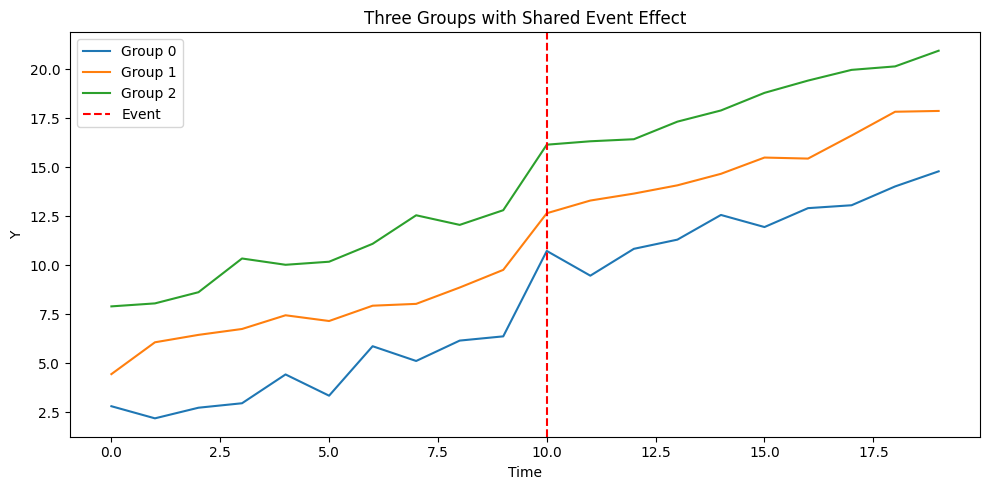

In [3]:
# Setup for three groups
np.random.seed(1)
t = np.tile(np.arange(20), 3)
group = np.repeat([0, 1, 2], 20)
baseline = np.array([2, 5, 8])
event_effect = 3

# Generate outcome
y2 = baseline[group] + 0.5 * t + np.random.normal(0, 0.5, len(t))
y2[t >= 10] += event_effect  # shared event shift

df2 = pd.DataFrame({'Y': y2, 'Time': t, 'Group': group, 'PostEvent': (t >= 10).astype(int)})

# Plot the group trends
plt.figure(figsize=(10, 5))
for g in df2['Group'].unique():
    group_data = df2[df2['Group'] == g]
    plt.plot(group_data['Time'], group_data['Y'], label=f'Group {g}')
plt.axvline(10, color='red', linestyle='--', label='Event')
plt.title('Three Groups with Shared Event Effect')
plt.xlabel('Time')
plt.ylabel('Y')
plt.legend()
plt.tight_layout()
plt.show()

# Build fixed effects model
X = pd.get_dummies(df2[['Group', 'Time']], drop_first=True)
X['PostEvent'] = df2['PostEvent']
X = sm.add_constant(X)

model_fe = sm.OLS(df2['Y'], X).fit()


I simulated three groups that each started at a different baseline but followed the same upward trend over time. At time = 10, all three groups experienced the same event effect—a sudden, equal jump in their outcome values. The key idea was to model this in a way that separates each group’s starting level from the shared impact of the event.

To do that, I used a fixed effects model that included both group and time dummies along with an event indicator. The fixed effects control for baseline differences across groups and any shared changes over time. The model then isolates the actual treatment effect—how much the outcome shifted after the event, across all groups.

The plot shows each group’s values rising in parallel, with a clear upward shift after time = 10. Because the fixed effects absorb the group-level and time-level variation, the model cleanly estimates the treatment effect (β) without mistaking baseline gaps for part of the event’s impact.

This approach helped reinforce how event studies and fixed effects work together. When multiple units experience a common intervention but start from different baselines, this combination allows for a more accurate and unbiased estimate of the treatment effect.